In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from keras_flops import get_flops

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc

In [3]:
# Read and examine metadata
#raw_data = pd.read_csv(r"D:\NITK\COVID-19 Lung CT Scan Segmentation\COVID-19 Lung CT Scan Segmentation\metadata.csv")
raw_data = pd.read_csv(r'../COVID-19 Lung CT Scan Segmentation/COVID-19 Lung CT Scan Segmentation/metadata_temp.csv')
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
10,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
8,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
9,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
4,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Read sample
sample_ct   = read_nii(raw_data.loc[1,'ct_scan'])
sample_lung = read_nii(raw_data.loc[1,'lung_mask'])
sample_infe = read_nii(raw_data.loc[1,'infection_mask'])
sample_all  = read_nii(raw_data.loc[1,'lung_and_infection_mask'])

# Examine Shape
sample_ct.shape

(512, 512, 200)

Text(0.5, 1.0, 'Lung and Infection Mask')

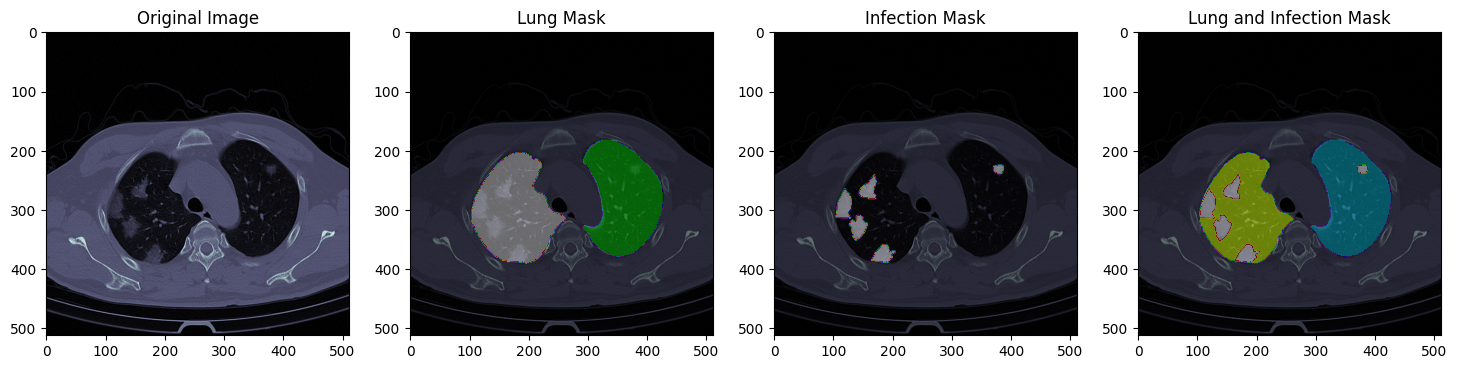

In [6]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [7]:
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 1

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def get_data():
    lungs_data = []
    infections_data  = []

    for row in range(len(raw_data)):
        lungs_image = read_nii(raw_data['ct_scan'][row])
        infection_image = read_nii(raw_data['infection_mask'][row])

        for slice_no in range(lungs_image.shape[2]):
            lung_slice = cv2.resize(lungs_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            infection_slice = cv2.resize(infection_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')

            lung_slice_temp = lung_slice.reshape(-1, 2)
            lung_slice_temp = scaler.fit_transform(lung_slice_temp)
            lung_slice = lung_slice_temp.reshape(lung_slice.shape)
            lungs_data.append(lung_slice[..., np.newaxis])

            infections_data.append(infection_slice[..., np.newaxis])
    return lungs_data, infections_data

In [9]:
data = get_data()
lungs = np.array(data[0])
infections = np.array(data[1])

Text(0.5, 1.0, 'Transformed Infection Mask')

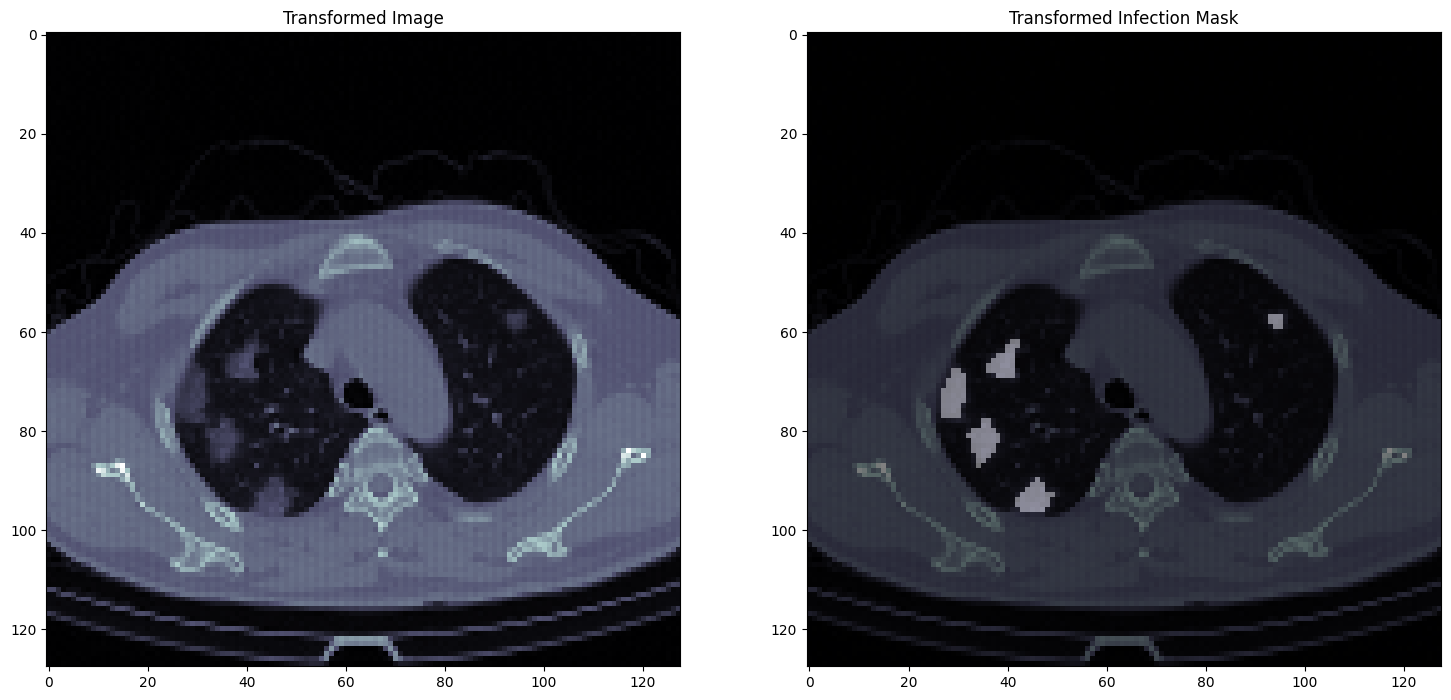

In [10]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
plt.imshow(lungs[451], cmap = 'bone')
plt.title('Transformed Image')

plt.subplot(1,2,2)
plt.imshow(lungs[451], cmap = 'bone')
plt.imshow(infections[451],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Transformed Infection Mask')

In [11]:
# Split the data into train and test sets
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size=0.1, shuffle=True)


In [12]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [13]:
"""Modified"""
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, GaussianNoise

In [14]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Augmentation
    aug = RandomRotation(10)(input_img)
    aug = RandomZoom(0.1)(aug)
    aug = RandomContrast(0.1)(aug)
    aug = GaussianNoise(10)(aug)
    input_img = aug  

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

In [16]:
from keras import backend as K
K.clear_session()

# Define the UNET model with TensorFlow's MeanIoU metric
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]  # Use MeanIoU as the Jaccard Index metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)  # Use custom Jaccard loss

gc.collect()

918

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[1][0]']                 
 alization)                     )                                                             

In [18]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
]

In [19]:
results = model.fit(lung_train, infect_train, batch_size=8, epochs=50, callbacks=callbacks, validation_data=(lung_test, infect_test), use_multiprocessing=True)
     

Epoch 1/50
396/396 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9817 - auc: 0.5469 - sensitivity_at_specificity: 0.5212 - specificity_at_sensitivity: 0.5134 - mean_io_u: 0.4967
Epoch 1: val_loss improved from inf to 0.06351, saving model to model-Unet.h5
396/396 [==============================] - 34s 62ms/step - loss: 0.1852 - accuracy: 0.9817 - auc: 0.5469 - sensitivity_at_specificity: 0.5212 - specificity_at_sensitivity: 0.5134 - mean_io_u: 0.4967 - val_loss: 0.0635 - val_accuracy: 0.9935 - val_auc: 0.8686 - val_sensitivity_at_specificity: 0.9345 - val_specificity_at_sensitivity: 0.9889 - val_mean_io_u: 0.4968 - lr: 0.0010
Epoch 2/50
396/396 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9934 - auc: 0.9155 - sensitivity_at_specificity: 0.9169 - specificity_at_sensitivity: 0.9915 - mean_io_u: 0.4967
Epoch 2: val_loss improved from 0.06351 to 0.02763, saving model to model-Unet.h5
396/396 [==============================] - 25s 62ms/st

In [20]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
47,0.003651,0.998475,0.998676,0.997956,0.999983,0.496692,0.004251,0.998263,0.996439,0.993669,0.999964,0.496796,0.00001
45,0.003660,0.998468,0.998651,0.997909,0.999981,0.496692,0.004253,0.998256,0.996613,0.994021,0.999963,0.496796,0.00001
41,0.003674,0.998472,0.998604,0.997819,0.999980,0.496692,0.004255,0.998251,0.996747,0.994291,0.999965,0.496796,0.00001
48,0.003662,0.998472,0.998635,0.997877,0.999980,0.496692,0.004256,0.998255,0.996586,0.993966,0.999964,0.496796,0.00001
46,0.003664,0.998471,0.998610,0.997828,0.999979,0.496692,0.004258,0.998255,0.996492,0.993777,0.999963,0.496796,0.00001
42,0.003678,0.998464,0.998658,0.997929,0.999983,0.496692,0.004259,0.998257,0.996571,0.993939,0.999967,0.496796,0.00001
49,0.003650,0.998478,0.998584,0.997772,0.999983,0.496692,0.004260,0.998258,0.996545,0.993885,0.999963,0.496796,0.00001
40,0.003679,0.998465,0.998618,0.997848,0.999983,0.496692,0.004260,0.998254,0.996598,0.993994,0.999965,0.496796,0.00001
44,0.003664,0.998470,0.998662,0.997932,0.999983,0.496692,0.004260,0.998254,0.996558,0.993912,0.999964,0.496796,0.00001
43,0.003673,0.998469,0.998609,0.997828,0.999979,0.496692,0.004265,0.998246,0.996732,0.994264,0.999962,0.496796,0.00001


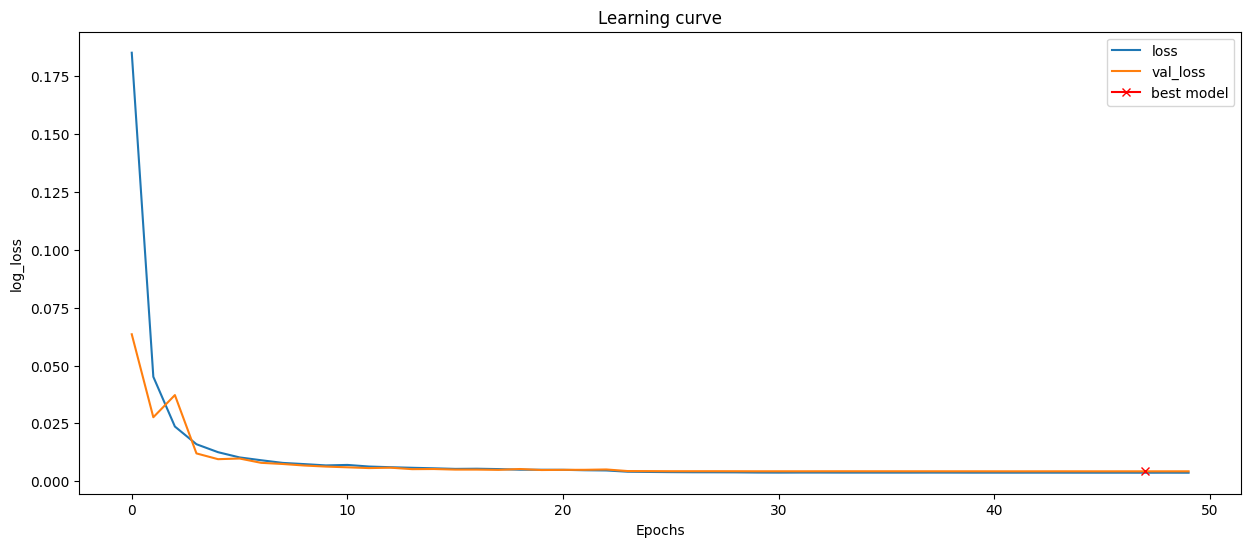

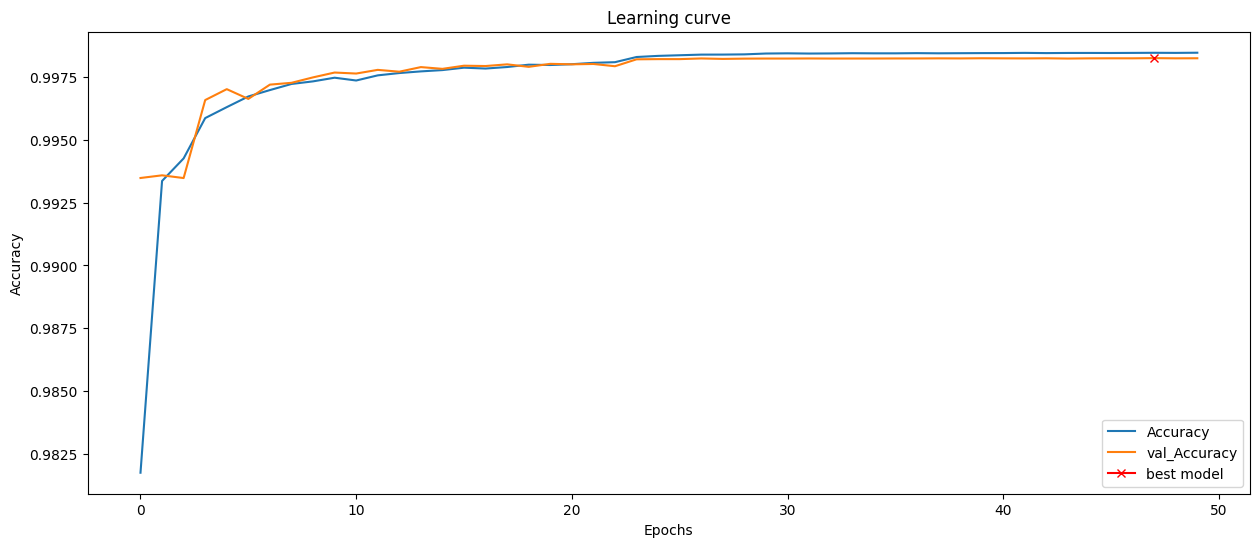

In [21]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
     

In [30]:
model.save("UNet.h5")

In [22]:
# Calculate metrics
predicted = model.predict(lung_test)

# Flatten the predicted and true masks
predicted_flat = np.round(predicted.flatten())
infect_test_flat = infect_test.flatten()

In [23]:
# Calculate metrics for training data
train_predicted = model.predict(lung_train)

# Flatten the predicted and true masks
train_predicted_flat = np.round(train_predicted.flatten())
infect_train_flat = infect_train.flatten()

# Calculate precision and recall for training data
train_precision = Precision()
train_recall = Recall()
train_precision.update_state(infect_train_flat, train_predicted_flat)
train_recall.update_state(infect_train_flat, train_predicted_flat)

# Calculate F1 score for training data
train_f1_score = 2 * (train_precision.result() * train_recall.result()) / (train_precision.result() + train_recall.result())

# Calculate accuracy for training data
train_accuracy = np.mean(train_predicted_flat == infect_train_flat)

# Calculate metrics for testing data
test_predicted = model.predict(lung_test)

# Flatten the predicted and true masks for testing data
test_predicted_flat = np.round(test_predicted.flatten())
infect_test_flat = infect_test.flatten()

# Calculate precision and recall for testing data
test_precision = Precision()
test_recall = Recall()
test_precision.update_state(infect_test_flat, test_predicted_flat)
test_recall.update_state(infect_test_flat, test_predicted_flat)

# Calculate F1 score for testing data
test_f1_score = 2 * (test_precision.result() * test_recall.result()) / (test_precision.result() + test_recall.result())

# Calculate accuracy for testing data
test_accuracy = np.mean(test_predicted_flat == infect_test_flat)

# Calculate parameters
total_parameters = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

# Calculate FLOPs
flops = get_flops(model, batch_size=1)  # Assuming batch_size = 1

# Print the metrics for training data
print("Training Metrics:")
print("Precision: ", train_precision.result().numpy())
print("Recall: ", train_recall.result().numpy())
print("F1 Score: ", train_f1_score.numpy())
print("Accuracy: ", train_accuracy)

# Print the metrics for testing data
print("\nTesting Metrics:")
print("Precision: ", test_precision.result().numpy())
print("Recall: ", test_recall.result().numpy())
print("F1 Score: ", test_f1_score.numpy())
print("Accuracy: ", test_accuracy)

# Print the other metrics
print("\nTotal Parameters: ", total_parameters)
print("FLOPs: ", flops)


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Training Metrics:
Precision:  0.8909276
Recall:  0.8902686
F1 Score:  0.890598
Accuracy:  0.9985529967028686

Testing Metrics:
Precision:  0.868452
Recall:  0.8580898
F1 Score:  0.8632398
Accuracy:  0.9982575503262606

Total Parameters:  2161361
FLOPs:  1597694592


In [24]:
device = "CPU:0"

In [25]:
with tf.device(device):
    # Calculate Jaccard Index (MeanIoU) for training data
    train_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    train_iou.update_state(infect_train_flat, train_predicted_flat)
    train_mean_iou = train_iou.result().numpy()

    # Calculate Jaccard Index (MeanIoU) for testing data
    test_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    test_iou.update_state(infect_test_flat, test_predicted_flat)
    test_mean_iou = test_iou.result().numpy()

    # Print the Jaccard Index (MeanIoU) for training and testing data
    print("Training Jaccard Index (MeanIoU): ", train_mean_iou)
    print("Testing Jaccard Index (MeanIoU): ", test_mean_iou)


Training Jaccard Index (MeanIoU):  0.89915824
Testing Jaccard Index (MeanIoU):  0.87881696


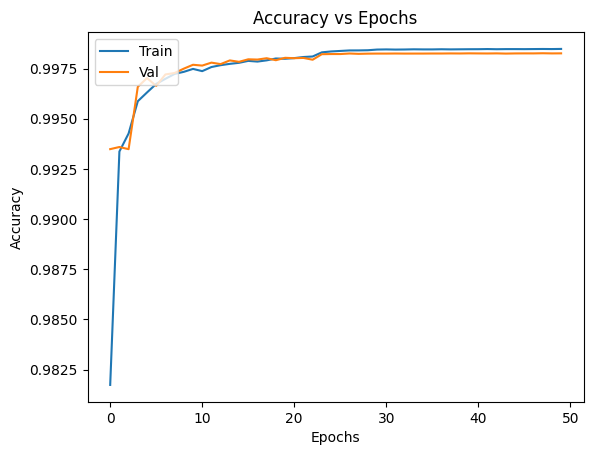

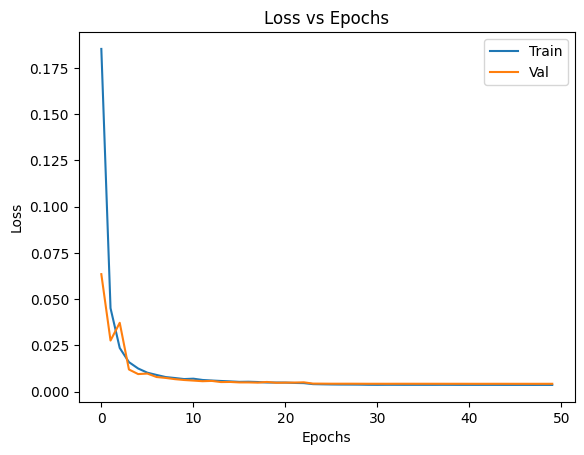

In [26]:
# Plot accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [27]:
with tf.device(device):
    # Make predictions
    predicted = model.predict(lung_test)

Text(0.5, 1.0, 'Predicted infection mask')

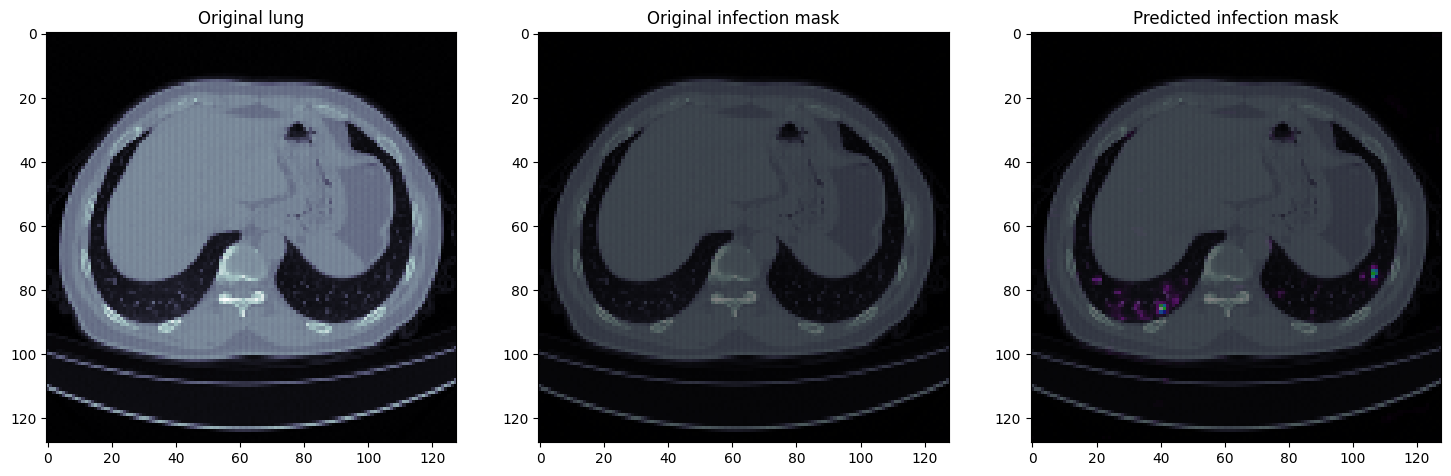

In [34]:
# Make predictions and visualize
img_num = 3
predicted = model.predict(lung_test)

# Visualize results
fig = plt.figure(figsize=(18, 15))
plt.subplot(1, 3, 1)
plt.imshow(lung_test[img_num], cmap='bone')
plt.title('Original lung')

plt.subplot(1, 3, 2)
plt.imshow(lung_test[img_num], cmap='bone')
plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
plt.title('Original infection mask')

plt.subplot(1, 3, 3)
plt.imshow(lung_test[img_num], cmap='bone')
plt.imshow(predicted[img_num], alpha=0.5, cmap="nipy_spectral")
plt.title('Predicted infection mask')

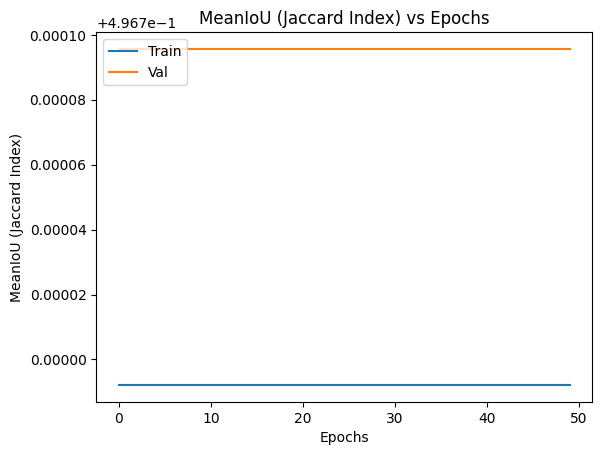

In [29]:
# Plot Jaccard Index (MeanIoU)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('MeanIoU (Jaccard Index) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU (Jaccard Index)')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()